# Занятие 2: Метод k-ближайших соседей

In [1]:
# https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761

## Загружаем библиотеки

In [2]:
import numpy as np
import pandas as pd
import requests
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize

import csv

## Загружаем и анализируем датасет о смертности от рака в разных штатах

In [3]:
data_file = "../data/cancer_regr.csv"
df = pd.read_csv(data_file, encoding = "utf-8" , engine='python')
print(df.columns)


Index(['avgAnnCount', 'avgDeathsPerYear', 'TARGET_deathRate', 'incidenceRate',
       'medIncome', 'popEst2015', 'povertyPercent', 'studyPerCap', 'binnedInc',
       'MedianAge', 'MedianAgeMale', 'MedianAgeFemale', 'Geography',
       'AvgHouseholdSize', 'PercentMarried', 'PctNoHS18_24', 'PctHS18_24',
       'PctSomeCol18_24', 'PctBachDeg18_24', 'PctHS25_Over',
       'PctBachDeg25_Over', 'PctEmployed16_Over', 'PctUnemployed16_Over',
       'PctPrivateCoverage', 'PctPrivateCoverageAlone', 'PctEmpPrivCoverage',
       'PctPublicCoverage', 'PctPublicCoverageAlone', 'PctWhite', 'PctBlack',
       'PctAsian', 'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate',
       'Unnamed: 34'],
      dtype='object')


### Убираем случаи где есть проблемы с данными

In [4]:
df = df.dropna()

### Объединяем

In [5]:
df_poverty =  df['povertyPercent']
df_death_rate = df['TARGET_deathRate']
df = pd.concat([df_poverty, df_death_rate], axis=1).dropna()

### Визуализируем данные

No handles with labels found to put in legend.


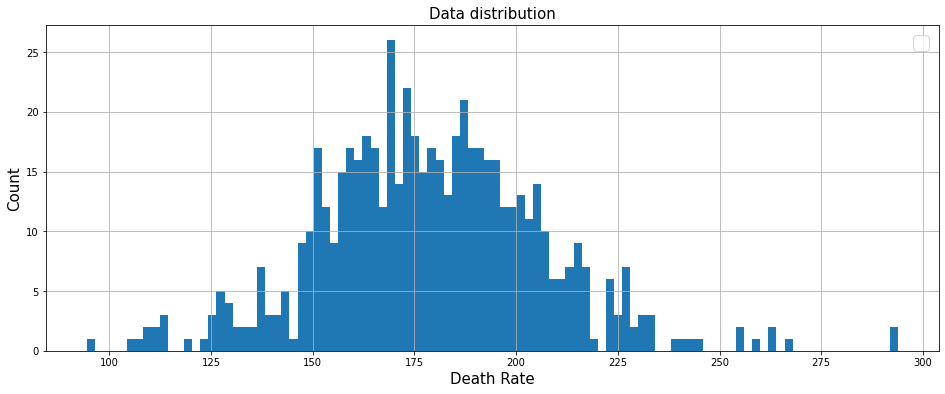

In [6]:
df['TARGET_deathRate'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Death Rate', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


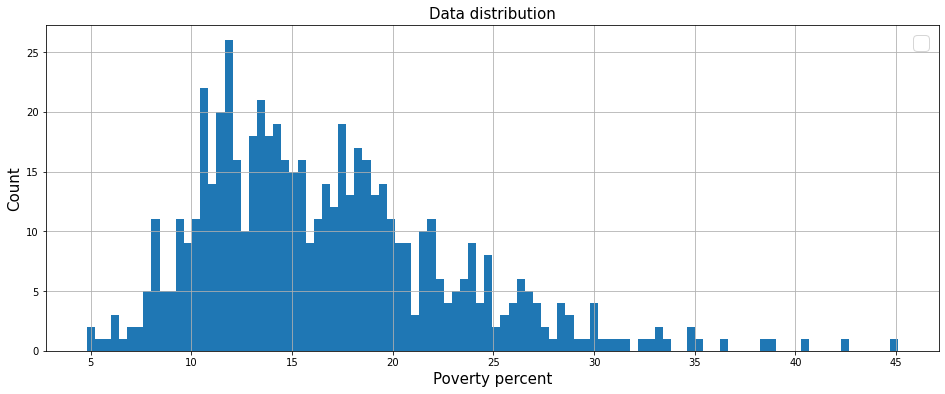

In [7]:
df['povertyPercent'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Poverty percent', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

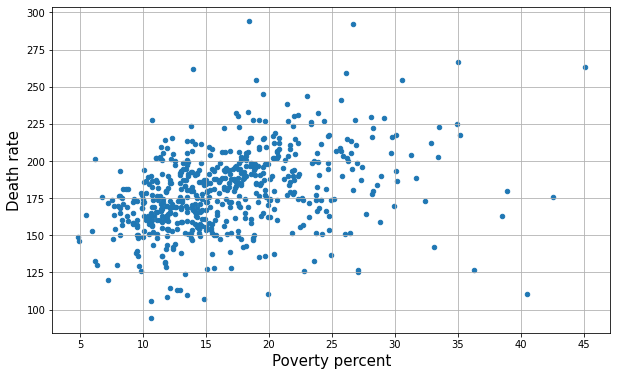

In [8]:
df.plot.scatter('povertyPercent', 'TARGET_deathRate', figsize=(10,6))
plt.xlabel('Poverty percent', fontsize=15)
plt.ylabel('Death rate', fontsize=15)
plt.grid()

## Найдем и уберем outlier

In [9]:
# Найти outlier
z = np.abs(stats.zscore(df))
threshold = 3
print(np.where(z > threshold))

# Убрать outlier
df = df[(z < threshold).all(axis=1)]

(array([ 28, 197, 249, 420, 422, 447, 475, 477, 488, 488, 490, 514]), array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]))


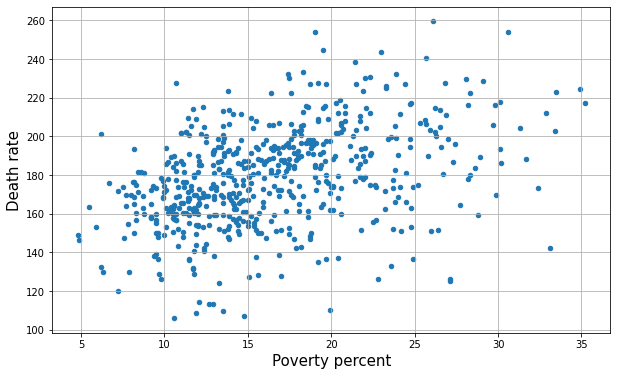

In [10]:
# Еще раз визуализируем
df.plot.scatter('povertyPercent', 'TARGET_deathRate', figsize=(10,6))
plt.xlabel('Poverty percent', fontsize=15)
plt.ylabel('Death rate', fontsize=15)
plt.grid()

## Нормализируем дата

In [11]:
# Poverty
mu_poverty = df['povertyPercent'].mean()
sigma_poverty = df['povertyPercent'].std()
scaled_poverty = (df['povertyPercent'].values-mu_poverty)/sigma_poverty
x_data = np.expand_dims(scaled_poverty, axis=1)

# Death Rate
mu_death_r = df['TARGET_deathRate'].mean()
sigma_death_r = df['TARGET_deathRate'].std()
scaled_death_r = (df['TARGET_deathRate'].values-mu_death_r)/sigma_death_r
y_data = np.expand_dims(scaled_death_r, axis=1)

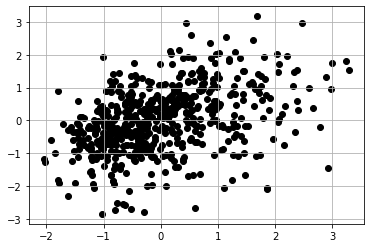

In [12]:
# Еще раз визуализируем
plt.scatter(x_data, y_data,  color='black')
plt.grid()

## Разделяем дата на выборки

In [13]:
# 20% данных будем использовать как validation dataset
val_size = 0.2

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=val_size, shuffle=True)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in val set: {0}.'.format(len(X_val)))
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in val data: {}".format(X_val.shape))
print("Shape of output in val data: {}".format(y_val.shape))

Data points in train set: 464.
Data points in val set: 116.
Shape of features in training data: (464, 1)
Shape of output in training data: (464, 1)
Shape of features in val data: (116, 1)
Shape of output in val data: (116, 1)


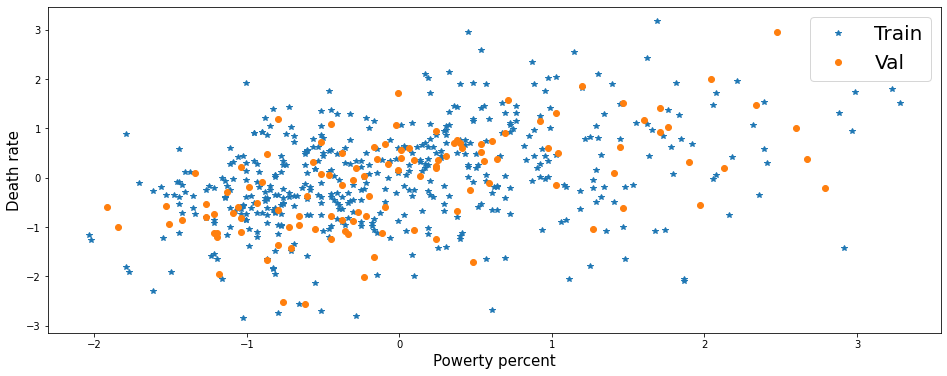

In [14]:
# Посмотрить показательный ли validation dataset
plt.figure(figsize=(16,6))
plt.plot(X_train, y_train, '*', label='Train')
plt.plot(X_val, y_val, 'o', label='Val')
plt.xlabel('Powerty percent', fontsize=15)
plt.ylabel('Death rate', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Применяем метод К ближайших соседей

In [15]:
# Потроим "модель"
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
K = 33
knn = KNeighborsRegressor(n_neighbors=K) #, weights = "distance")
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=33)

In [16]:
# Применяем
y_pred = knn.predict(X_val)

# Посчитаем Коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.2f'
      % r2_score(y_val, y_pred))

Coefficient of determination: 0.27


In [17]:
# побробуем разные значения К

## Сравним с линейной регрессией

No handles with labels found to put in legend.


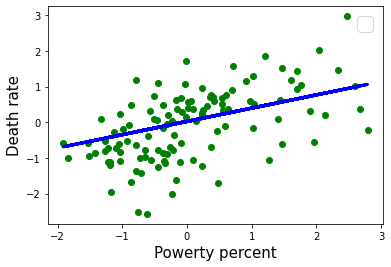

In [18]:
# Построим регрессию
regr = LinearRegression()
regr.fit(X_train, y_train)

# прогнозируем
y_pred = regr.predict(X_val)

# Визуализовать результат

# Plot outputs
plt.scatter(X_val, y_val,  color='green')
plt.plot(X_val, y_pred, color='blue', linewidth=3)

plt.xlabel('Powerty percent', fontsize=15)
plt.ylabel('Death rate', fontsize=15)
plt.legend(fontsize=20)

In [19]:
# Посчитаем Коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.2f'
      % r2_score(y_val, y_pred))

Coefficient of determination: 0.27


## Сравним с полиномиальной регрессией

Coefficient of determination: 0.27


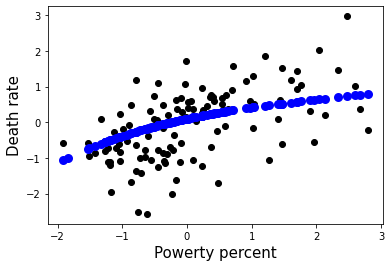

In [20]:
# Построить регрессию
# Задаем степень полинома
polynomial_degree = 3

# Описиваем полиновиальную регрессию
polyreg = make_pipeline(
        PolynomialFeatures(degree=polynomial_degree),
        LinearRegression()
        )

# Находим коефициенты
polyreg.fit(X_train, y_train)

# Предсказываем
ploy_load_pred = polyreg.predict(X_val)


# Считаем коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.2f'
      % r2_score(y_val, ploy_load_pred))

# Визуализируем
plt.scatter(X_val, y_val,  color='black')
plt.scatter(X_val, ploy_load_pred, color='blue', linewidth=3)

plt.xlabel('Powerty percent', fontsize=15)
plt.ylabel('Death rate', fontsize=15)

plt.show()

## Используем несколько фич на вход

In [22]:
# Загрузим датасет еще раз
data_file = "../data/cancer_regr.csv"
df = pd.read_csv(data_file, encoding = "utf-8" , engine='python')
print(df.columns)
df = df.dropna()


Index(['avgAnnCount', 'avgDeathsPerYear', 'TARGET_deathRate', 'incidenceRate',
       'medIncome', 'popEst2015', 'povertyPercent', 'studyPerCap', 'binnedInc',
       'MedianAge', 'MedianAgeMale', 'MedianAgeFemale', 'Geography',
       'AvgHouseholdSize', 'PercentMarried', 'PctNoHS18_24', 'PctHS18_24',
       'PctSomeCol18_24', 'PctBachDeg18_24', 'PctHS25_Over',
       'PctBachDeg25_Over', 'PctEmployed16_Over', 'PctUnemployed16_Over',
       'PctPrivateCoverage', 'PctPrivateCoverageAlone', 'PctEmpPrivCoverage',
       'PctPublicCoverage', 'PctPublicCoverageAlone', 'PctWhite', 'PctBlack',
       'PctAsian', 'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate',
       'Unnamed: 34'],
      dtype='object')


In [23]:
# Выберем дополнительную фичу: количество инцидентов
df_poverty =  df['povertyPercent']
df_incidence = df['incidenceRate']
df_death_rate = df['TARGET_deathRate']
df = pd.concat([df_poverty, df_incidence, df_death_rate], axis=1).dropna()

In [24]:
# Как всегда, уберем outlier
z = np.abs(stats.zscore(df))
threshold = 3
df = df[(z < threshold).all(axis=1)]

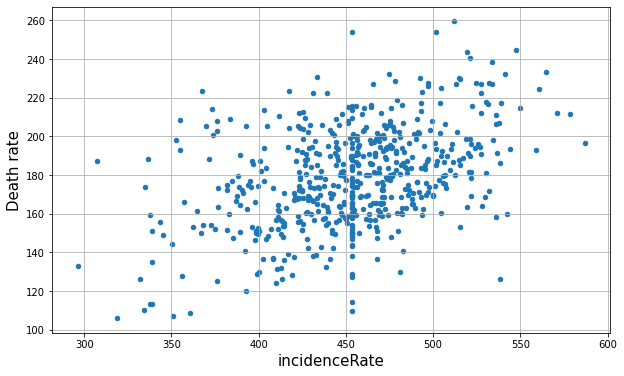

In [25]:
# Еще раз визуализируем
df.plot.scatter('incidenceRate', 'TARGET_deathRate', figsize=(10,6))
plt.xlabel('incidenceRate', fontsize=15)
plt.ylabel('Death rate', fontsize=15)
plt.grid()

In [26]:
# Нормализируем данные

# Poverty
mu_poverty = df['povertyPercent'].mean()
sigma_poverty = df['povertyPercent'].std()
scaled_poverty = (df['povertyPercent'].values-mu_poverty)/sigma_poverty

# Incident rate
mu_incident = df['incidenceRate'].mean()
sigma_incident = df['incidenceRate'].std()
scaled_incident = (df['incidenceRate'].values-mu_incident)/sigma_incident

x_data =np.array([scaled_poverty,scaled_incident]).transpose()

# Death Rate
mu_death_r = df['TARGET_deathRate'].mean()
sigma_death_r = df['TARGET_deathRate'].std()
scaled_death_r = (df['TARGET_deathRate'].values-mu_death_r)/sigma_death_r
y_data = np.expand_dims(scaled_death_r, axis=1)

In [27]:
# check dimensions
print(x_data.shape)
print(y_data.shape)

(575, 2)
(575, 1)


In [28]:
## Разделяем дата на выборки
val_size = 0.2

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=val_size, shuffle=True)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in val set: {0}.'.format(len(X_val)))
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in val data: {}".format(X_val.shape))
print("Shape of output in val data: {}".format(y_val.shape))

Data points in train set: 460.
Data points in val set: 115.
Shape of features in training data: (460, 2)
Shape of output in training data: (460, 1)
Shape of features in val data: (115, 2)
Shape of output in val data: (115, 1)


## Применяем метод К ближайших соседей в многоразмерном случае

In [29]:
# Потроим "модель"
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
K = 35
knn = KNeighborsRegressor(n_neighbors=K, weights = "distance")
knn.fit(X_train, y_train)

# Применяем
y_pred = knn.predict(X_val)

# Посчитаем Коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.2f'
      % r2_score(y_val, y_pred))

Coefficient of determination: 0.36


## Сравним с полиномиальной регрессией

In [30]:
# Построить регрессию
# Задаем степень полинома
polynomial_degree = 3

# Описиваем полиновиальную регрессию
polyreg = make_pipeline(
        PolynomialFeatures(degree=polynomial_degree),
        LinearRegression()
        )

# Находим коефициенты
polyreg.fit(X_train, y_train)

# Предсказываем
ploy_load_pred = polyreg.predict(X_val)


# Считаем коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.2f'
      % r2_score(y_val, ploy_load_pred))

Coefficient of determination: 0.31
